check_ra_dec_cz_s_mu_double> Out of range values found for cz. Expected input to be `cz' but found `z' instead. max_cz (found in input) = 0.199998 threshold = 10.000000


check_ra_dec_cz_s_mu_double> Out of range values found for cz. Expected input to be `cz' but found `z' instead. max_cz (found in input) = 0.199999 threshold = 10.000000


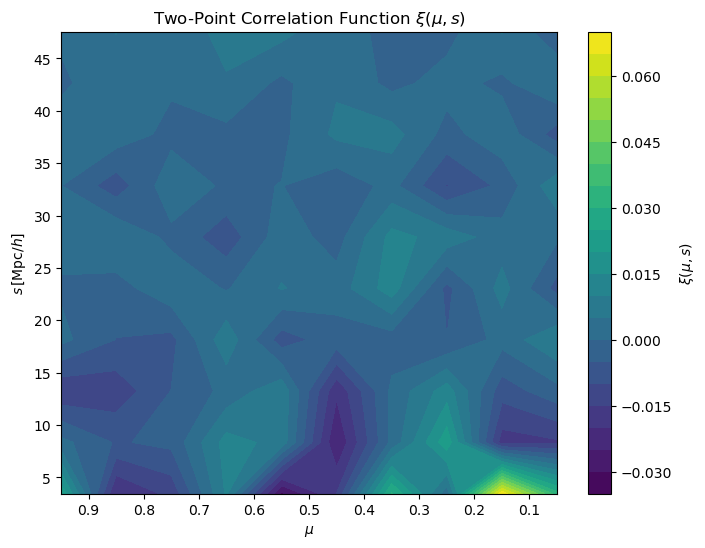

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.mocks import DDsmu_mocks
from Corrfunc.utils import convert_3d_counts_to_cf

# Step 1: Generate mock data
def generate_mock_data(num_galaxies=10000, ra_range=(150, 180), dec_range=(0, 10), z_range=(0.1, 0.2)):
    """Generate mock galaxy data with RA, DEC in degrees and redshift."""
    ra = np.random.uniform(ra_range[0], ra_range[1], num_galaxies)
    dec = np.random.uniform(dec_range[0], dec_range[1], num_galaxies)
    redshift = np.random.uniform(z_range[0], z_range[1], num_galaxies)
    return ra, dec, redshift

# Step 2: Convert RA, DEC, z to Cartesian coordinates
# def redshift_to_comoving_distance(z, H0=70.0, Omega_m=0.3):
#     """Convert redshift to comoving distance using a flat Lambda-CDM model."""
#     from scipy.integrate import quad

#     c = 3e5  # Speed of light in km/s
#     E = lambda z: np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))
#     distance, _ = quad(lambda z: c / (H0 * E(z)), 0, z)
#     return distance

# def ra_dec_z_to_cartesian(ra, dec, z):
#     """Convert RA, DEC, and redshift to Cartesian coordinates (x, y, z)."""
#     ra_rad = np.radians(ra)
#     dec_rad = np.radians(dec)
#     comoving_distance = np.array([redshift_to_comoving_distance(zi) for zi in z])
#     x = comoving_distance * np.cos(dec_rad) * np.cos(ra_rad)
#     y = comoving_distance * np.cos(dec_rad) * np.sin(ra_rad)
#     z = comoving_distance * np.sin(dec_rad)
#     return x, y, z

# Step 3: Create random catalog
def generate_random_catalog(num_randoms, ra_range, dec_range, z_range):
    """Generate a random catalog with uniform RA, DEC, and redshift."""
    ra, dec, redshift = generate_mock_data(num_randoms, ra_range, dec_range, z_range)
    return ra, dec, redshift

# Step 4: Run Corrfunc to compute xi(mu, s)
def calculate_xi_mu_s(ra, dec, z, num_randoms=100000, bins=np.linspace(1, 50, 11), nmu_bins=10):
    """Calculate xi(mu, s) using Corrfunc."""
    # Convert RA, DEC, z to Cartesian coordinates
    # x, y, z = ra_dec_z_to_cartesian(ra, dec, z)

    # Generate random catalog
    ra_random, dec_random, z_random = generate_random_catalog(num_randoms, (150, 180), (0, 10), (0.1, 0.2))
    #x_random, y_random, z_random = ra_dec_z_to_cartesian(ra_random, dec_random, z_random)

    # Pair counts with Corrfunc
    DD_counts = DDsmu_mocks(1, 1, binfile=bins, nmu_bins=nmu_bins, \
        RA1=ra, DEC1=dec, CZ1=z,\
            mu_max=1., nthreads=1)
    DR_counts = DDsmu_mocks(0, 1, binfile=bins, nmu_bins=nmu_bins, \
        RA1=ra, DEC1=dec, CZ1=z, RA2=ra_random, DEC2=dec_random, CZ2=z_random,\
            mu_max=1., nthreads=1)
    RR_counts = DDsmu_mocks(1, 1, binfile=bins, nmu_bins=nmu_bins, \
        RA1=ra_random, DEC1=dec_random, CZ1=z_random,\
            mu_max=1., nthreads=1)

    # Convert to correlation function
    xi = convert_3d_counts_to_cf(len(ra), len(ra), len(ra_random), len(ra_random), \
        DD_counts, DR_counts, DR_counts, RR_counts)
    return xi

# Step 5: Plot xi(mu, s)
def plot_xi_mu_s(xi, bins, nmu_bins):
    """Plot xi(mu, s) as a heatmap."""
    s_bins = 0.5 * (bins[:-1] + bins[1:])  # Midpoints of s bins
    mu_bins = np.linspace(0, 1, nmu_bins + 1)
    mu_bin_centers = 0.5 * (mu_bins[:-1] + mu_bins[1:])  # Midpoints of mu bins
    xi = xi.reshape(nmu_bins,len(s_bins))

    plt.figure(figsize=(8, 6))
    plt.imshow(xi.T, extent=(s_bins[0], s_bins[-1], 0, 1), origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label=r'$\xi(\mu, s)$')
    plt.xlabel(r'$s \, [\mathrm{Mpc}/h]$')
    plt.ylabel(r'$\mu$')
    plt.title(r'Two-Point Correlation Function $\xi(\mu, s)$')
    plt.show()

# Step 5: Plot xi(mu, s)
def plot_xi_mu_s_contours(xi, bins, nmu_bins):
    """Plot xi(mu, s) as a contour plot with s on the y-axis and mu on the inverted x-axis."""
    s_bins = 0.5 * (bins[:-1] + bins[1:])  # Midpoints of s bins
    mu_bins = np.linspace(0, 1, nmu_bins + 1)
    mu_bin_centers = 0.5 * (mu_bins[:-1] + mu_bins[1:])  # Midpoints of mu bins

    xi = xi.reshape(len(s_bins), nmu_bins)

    # Create the contour plot
    plt.figure(figsize=(8, 6))
    cs = plt.contourf(mu_bin_centers, s_bins, xi, levels=20, cmap='viridis')  # Invert mu
    cbar = plt.colorbar(cs)
    cbar.set_label(r'$\xi(\mu, s)$')

    plt.gca().invert_xaxis()

    plt.xlabel(r'$\mu$')  # Negative mu since it's inverted
    plt.ylabel(r'$s \, [\mathrm{Mpc}/h]$')
    plt.title(r'Two-Point Correlation Function $\xi(\mu, s)$')
    plt.show()

# Main execution
if __name__ == "__main__":
    # Generate mock data
    ra, dec, z = generate_mock_data()

    # Calculate xi(mu, s)
    bins = np.linspace(1, 50, 11)  # Separation bins in Mpc/h
    nmu_bins = 10  # Number of mu bins
    xi = calculate_xi_mu_s(ra, dec, z, bins=bins, nmu_bins=nmu_bins)

    # Plot xi(mu, s)
    plot_xi_mu_s_contours(xi, bins, nmu_bins)


### Now use the SDSS

84814
307395
NaNs in RA1: 0
NaNs in DEC1: 0
NaNs in CZ1: 0
NaNs in RA2: 0
NaNs in DEC2: 0
NaNs in CZ2: 0


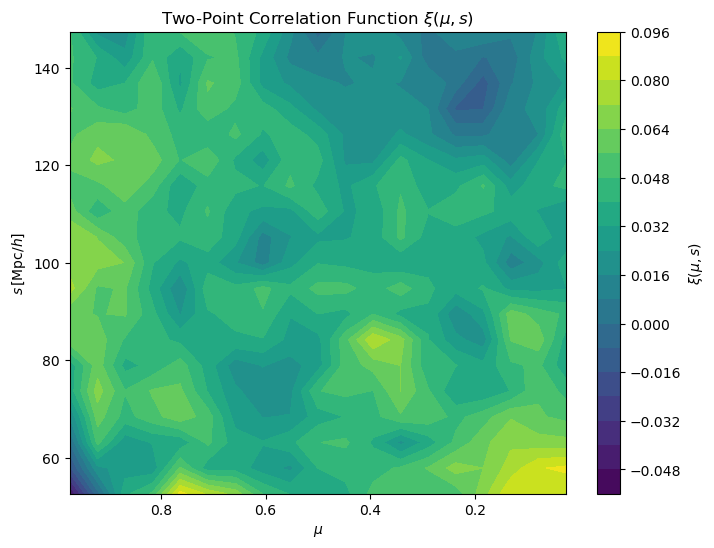

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.mocks import DDsmu_mocks
from Corrfunc.utils import convert_3d_counts_to_cf
import pandas as pd 
import healpy as hp
from scipy.interpolate import interp1d
from numpy.polynomial.polynomial import Polynomial

# Step 1: Read data and randoms
def read_data(zmin=0.05,zmax=0.15):
    # Load your data and randoms as Pandas DataFrames
    sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
    sdss  = sdss[(sdss["red"] > zmin)&(sdss["red"] < zmax)]
    return sdss

def read_randoms(filename):
    randoms = pd.read_csv(filename) 
    return randoms


# Step 3: Create random catalog
def build_cdf_from_parabola(data, num_points=10000):
    # Create a histogram of the redshifts
    vmin, vmax = data.min(), data.max()
    hist, bin_edges = np.histogram(data, bins=50, range=(vmin, vmax), density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Fit a parabola (second-degree polynomial) to the histogram
    poly = Polynomial.fit(bin_centers, hist, deg=2)
    z_vals = np.linspace(vmin, vmax, num_points)
    pdf_vals = poly(z_vals)

    # Ensure the PDF is positive and normalized
    pdf_vals = np.clip(pdf_vals, a_min=0, a_max=None)
    pdf_vals /= np.trapz(pdf_vals, z_vals)  # Normalize the PDF

    # Build the CDF
    cdf_vals = np.cumsum(pdf_vals) * (z_vals[1] - z_vals[0])
    cdf_vals /= cdf_vals[-1]  # Normalize to [0, 1]

    # Create inverse CDF via interpolation
    cdf_inv = interp1d(cdf_vals, z_vals, bounds_error=False, fill_value=(vmin, vmax))
    return cdf_inv, z_vals, pdf_vals, cdf_vals
  
def generate_random_catalog(nrand, data, nside=128, write=False):
    """Generate a random catalog with uniform RA, DEC, and redshift."""
    # Set the resolution (nside)
    #nside = 128  # Approx 55 arcmin resolution (adjust as needed)
    #nrand = 20 # Times the size of the data (around 10% is left after mask)

    ra = data['ra'].values
    dec = data['dec'].values
    z = data['red'].values

    # Total number of pixels in the map
    npix = hp.nside2npix(nside)

    # Initialize a mask array (1 = valid, 0 = invalid)
    mask = np.zeros(npix, dtype=int)

    # Convert RA, Dec to Healpix indices
    theta = np.radians(90 - dec)  # Declination to colatitude
    phi = np.radians(ra)          # Right Ascension to longitude
    pixels = hp.ang2pix(nside, theta, phi)

    # Mark these pixels as valid
    mask[pixels] = 1

    num_randoms = len(ra)*nrand  # Number of random points

    # Generate uniform random RA, Dec
    ra_random = np.random.uniform(0, 360, num_randoms)  # RA: 0 to 360 degrees
    dec_random = np.random.uniform(-90, 90, num_randoms)  # Dec: -90 to 90 degrees

    # Convert RA, Dec to Healpix indices
    theta_random = np.radians(90 - dec_random)
    phi_random = np.radians(ra_random)
    random_pixels = hp.ang2pix(nside, theta_random, phi_random)

    # Apply the mask
    valid_indices = mask[random_pixels] == 1
    ra_random = ra_random[valid_indices]
    dec_random = dec_random[valid_indices]

    # Read redshift distribution and apply to randoms
    # Build the inverse CDF from a smoothed KDE fit
    cdf_inv_z, z_vals, pdf_vals, cdf_vals = build_cdf_from_parabola(z)

    # Generate random redshifts
    u = np.random.uniform(0, 1, len(ra_random))
    red_random = cdf_inv_z(u)

    random_data = pd.DataFrame({
        'ra': ra_random,
        'dec': dec_random,
        'red': red_random
    })

    print(len(ra))
    print(len(ra_random))

    if write==True: random_data.to_csv(f'../data/random_sample_healpy_{nside}_{len(random_data)}.csv', index=False)

    return random_data

# Step 4: Run Corrfunc to compute xi(mu, s)
def calculate_xi_mu_s(ra_data, dec_data, z_data, ra_rand, dec_rand, z_rand, bins, nmu_bins):
    """Calculate xi(mu, s) using Corrfunc."""

    # Pair counts with Corrfunc
    DD_counts = DDsmu_mocks(1, 2, binfile=bins, nmu_bins=nmu_bins, \
        RA1=ra_data, DEC1=dec_data, CZ1=3e5*z_data,\
            mu_max=1., nthreads=1)
    DR_counts = DDsmu_mocks(0, 2, binfile=bins, nmu_bins=nmu_bins, \
        RA1=ra_data, DEC1=dec_data, CZ1=3e5*z_data, RA2=ra_rand, DEC2=dec_rand, CZ2=3e5*z_rand,\
            mu_max=1., nthreads=4)
    RR_counts = DDsmu_mocks(1, 2, binfile=bins, nmu_bins=nmu_bins, \
        RA1=ra_rand, DEC1=dec_rand, CZ1=3e5*z_rand,\
            mu_max=1., nthreads=4)

    # Convert to correlation function
    xi = convert_3d_counts_to_cf(len(ra_data), len(ra_data), len(ra_rand), len(ra_rand), \
        DD_counts, DR_counts, DR_counts, RR_counts)
    return xi

# # Step 5: Plot xi(mu, s)
# def plot_xi_mu_s(xi, bins, nmu_bins):
#     """Plot xi(mu, s) as a heatmap."""
#     s_bins = 0.5 * (bins[:-1] + bins[1:])  # Midpoints of s bins
#     mu_bins = np.linspace(0, 1, nmu_bins + 1)
#     mu_bin_centers = 0.5 * (mu_bins[:-1] + mu_bins[1:])  # Midpoints of mu bins
#     xi = xi.reshape(nmu_bins,len(s_bins))

#     plt.figure(figsize=(8, 6))
#     plt.imshow(xi.T, extent=(s_bins[0], s_bins[-1], 0, 1), origin='lower', aspect='auto', cmap='viridis')
#     plt.colorbar(label=r'$\xi(\mu, s)$')
#     plt.xlabel(r'$s \, [\mathrm{Mpc}/h]$')
#     plt.ylabel(r'$\mu$')
#     plt.title(r'Two-Point Correlation Function $\xi(\mu, s)$')
#     plt.show()

# Step 5: Plot xi(mu, s)
def plot_xi_mu_s_contours(xi, bins, nmu_bins):
    """Plot xi(mu, s) as a contour plot with s on the y-axis and mu on the inverted x-axis."""
    s_bins = 0.5 * (bins[:-1] + bins[1:])  # Midpoints of s bins
    mu_bins = np.linspace(0, 1, nmu_bins + 1)
    mu_bin_centers = 0.5 * (mu_bins[:-1] + mu_bins[1:])  # Midpoints of mu bins

    xi = xi.reshape(len(s_bins), nmu_bins)

    # Create the contour plot
    plt.figure(figsize=(8, 6))
    cs = plt.contourf(mu_bin_centers, s_bins, xi, levels=20, cmap='viridis')  
    cbar = plt.colorbar(cs)
    cbar.set_label(r'$\xi(\mu, s)$')

    plt.gca().invert_xaxis()

    plt.xlabel(r'$\mu$')  # Negative mu since it's inverted
    plt.ylabel(r'$s \, [\mathrm{Mpc}/h]$')
    plt.title(r'Two-Point Correlation Function $\xi(\mu, s)$')
    plt.show()

# Main execution
if __name__ == "__main__":

    zmin, zmax = 0.05, 0.15

    # Read data
    sdss = read_data(zmin,zmax)

    # Select filament galaxies
    sdss = sdss[sdss['dist_fil']<=3.]

    # Generate Randoms
    randoms = generate_random_catalog(40, sdss, nside=128, write=False)

    # Dilute for testing
    sdss = sdss.sample(n=40000)
    randoms = randoms[:120000]

    # Calculate xi(mu, s)
    ra_data = sdss['ra'].values
    dec_data = sdss['dec'].values
    z_data = sdss['red'].values
    ra_rand = randoms['ra'].values
    dec_rand = randoms['dec'].values
    z_rand = randoms['red'].values
    bins = np.linspace(50, 150, 20)  # Separation bins in Mpc/h
    nmu_bins = len(bins)-1  # Number of mu bins
    xi = calculate_xi_mu_s(ra_data, dec_data, z_data, ra_rand, dec_rand, z_rand, bins=bins, nmu_bins=nmu_bins)

    # Plot xi(mu, s)
    plot_xi_mu_s_contours(xi, bins, nmu_bins)



In [6]:
np.savez('2dcorr_corrfunc.npz', xi=xi, s=bins, mu=nmu_bins)


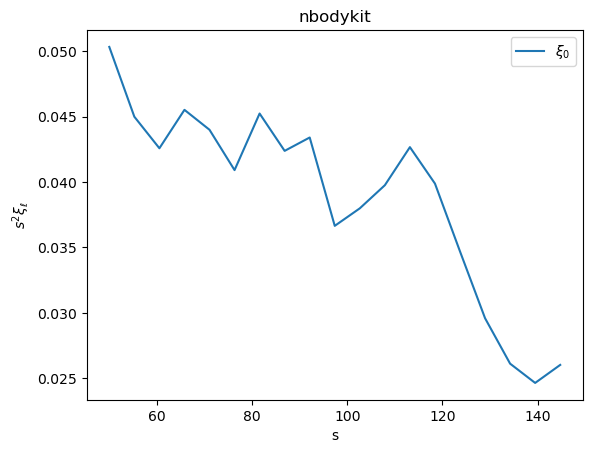

In [7]:
def get_xi0246(xi,mu,rs):
    
    import numpy as np
	
    #xi_sm = corr.corr.data['corr']

    nbins_s = len(rs)-1
    nbins_m = len(mu)

    #s_bins = 0.5 * (bins[:-1] + bins[1:])  # Midpoints of s bins
    #mu_bins = np.linspace(0, 1, nmu_bins + 1)
    #mu_bin_centers = 0.5 * (mu_bins[:-1] + mu_bins[1:])  # Midpoints of mu bins

    xi = xi.reshape(nbins_s, nbins_m)

    xi_sm = xi

    dmu = 1.0/nbins_m
    
    #rs = corr.D1D2.coords['r']
    #mu = corr.D1D2.coords['mu']
    
    xi_s0 = np.zeros(nbins_s)
    xi_s2 = np.zeros(nbins_s)
    xi_s4 = np.zeros(nbins_s)
    xi_s6 = np.zeros(nbins_s)
    
    sr = np.zeros(nbins_s)
    rm = np.zeros(nbins_m)
    
    l0 = 0.0
    l1 = 1.0
    l2 = 2.0
    l3 = 3.0
    
    for i in range(nbins_s):
    	
        sr[i] = rs[i]
		
        for j in range(nbins_m):
            rm[j]=mu[j]
            xi_s0[i]  += (4.0*l0+1.0)*xi_sm[i,j]*1.0*dmu 
            xi_s2[i]  += (4.0*l1+1.0)*xi_sm[i,j]*((3*rm[j]**2 - 1.0)/2.0)*dmu
            xi_s4[i]  += (4.0*l2+1.0)*xi_sm[i,j]*((35*rm[j]**4 - 30*rm[j]**2 + 3.0)/8.0)*dmu
            xi_s6[i]  += (4.0*l3+1.0)*xi_sm[i,j]*((231*rm[j]**6 - 315*rm[j]**4 + 105*rm[j]**2 - 5)/16.0)*dmu
    
    return xi_s0, xi_s2, xi_s4, xi_s6

# Load the data from the .npz file
file_path = '2dcorr_corrfunc.npz'
data = np.load(file_path)

s = data['s']  # Edges of s bins
mu = data['mu']  # Edges of mu bins
xi = data['xi']  # Structured array for 2D correlation function

xi_l = get_xi0246(xi,np.linspace(0,1,nmu_bins),bins)

#nr = 2.5+np.linspace(5.,150.,nbins_s+1)[:-1]
r = bins[:-1]
plt.plot(r,(xi_l[0]),label=r'$\xi_0$',c='C00')
#plt.plot(r,(-xi_l[1]),label=r'$\xi_2$',c='C01')
#plt.plot(r,(r**2)*(-xi_l[2]),label=r'$\xi_4$',c='C02')

plt.title('nbodykit')
plt.xlabel('s')
plt.ylabel(r'$s^2\xi_{\ell}$')
plt.legend()
plt.show()